# Lab 06.a: Introduction to Retrieval Augmented Generation (RAG)

All Foundation Models are trained on a snapshot of data at a specific time. Consequently, they are only aware of facts that were included in their training corpus. For instance, if you were to ask your Foundation Model about today's weather and whether it's a good idea to bring your family to the beach, it would likely be unable to answer your question. This limitation arises from the fact that the weather data for today was not part of its training data.

<center><img src="imgs/diag_rag_1.png" width="800" alt="Diagram of user interacting with FM"></center><br>

We can give it a try on [**watsonx.ai**](https://watsonx.ai) and see the results, with two different models.

First, let's use the `google/flan-ul2` model.

<center><img src="imgs/rag_1.png" width="800" alt="Flan-UL2 trying to answer questions about today's weather"></center><br>

Next, let's try with an instruct-tuned model, the `ibm/mpt-7b-instruct2` model.

<center><img src="imgs/rag_2.png" width="800" alt="MPT-7b-Instruct2 trying to answer questions about today's weather"></center><br>

Unfortunately, none of the results are satisfactory. This is because none of these models were trained on today's weather data. However, Foundation Models are trained on an extensive dataset covering a wide range of topics, making them proficient in linguistics and capable of learning from recent facts or information not included during their training, such as learning from your enterprise data.

**Retrieval Augmented Generation** (or **RAG**, for short) is a technique used to retrieve relevant data about a specific subject and provide it as context to the Foundation Model via your prompt.

With the same goal in mind, what if we could pass weather API data as context to the model and rephrase the same question? Do you think it would be able to generate a response?

<center><img src="imgs/diag_rag_2.png" width="800" alt="Diagram of user interacting with FM within a context"></center><br>

Let's see that in practice.

<center><img src="imgs/rag_3.png" width="800" alt="MPT-7b-Instruct2 working with context"></center><br>

The same principle applies to a document. Suppose you want your model to answer questions about a paragraph of text. In that case, you can pass this paragraph as context and have your model respond to questions related to it.

To demonstrate this point, we can ask a Foundation Model who the President of the United States is. However, it is unlikely that any of them will provide a concise and reliable answer. For instance, `GPT-3.5` gives the following response:

> *"As of my last knowledge update in September 2021, the President of the United States was Joe Biden. However, please note that my information might be outdated, and I don't have browsing capabilities to access real-time data. If the current date is after September 2021, I recommend checking a reliable news source or performing a quick online search to find the most up-to-date information on the current President of the United States."*

If we use the same approach as above and provide our models with some context, these will be the results.

<center><img src="imgs/rag_4.png" width="800" alt="MPT-7b-Instruct2 working with context"></center><br>

We can use multiple different data sources to augment our prompts, such as documents, databases, repositories, or APIs. However, to make this process practical and affordable, we need to perform a few preliminary steps.

Now, let's consider a scenario where you want your model to answer questions about a submarine's manual, and this manual spans 492 pages. Can we pass this manual as context, you might wonder?

<center><img src="imgs/diag_rag_3.png" width="800" alt="Diagram of user interacting with FM within a context"></center><br>

Well, this is definitely not the best approach. First of all, as you may have noticed, all the Foundation Models have a **Context Window**, which essentially represents the maximum number of tokens they can handle. This information is displayed at the bottom of our Prompt Studio page. Sending the entire manual would undoubtedly exceed the maximum token limit of **any** Foundation Model.

Even if it were possible to send the entire manual, each call to the model's API is charged based on the number of tokens used. Consequently, the longer our prompt, the more expensive it becomes. Just imagine processing this extensive number of tokens for each question!

This is where **Semantic Search** comes into play.

## Semantic Search

The idea here is to convert the whole document - or our collection of documents - into smaller chunks of text. There are many different approaches to do so, which we can discuss further ahead. But the main point is that we need to break it down into smaller pieces of text.

<center><img src="imgs/diag_rag_4.png" width="200" alt="Breaking a documento into chunks"></center><br>

After obtaining these smaller pieces of text, our goal is to take the user's question and identify which chunks of text are more likely to contain the answer. To determine this similarity, we need to convert each of these text pieces - including the question itself - into **Embeddings**.

Once we have our pieces of text represented as vectors, we can measure the distance between them. By doing so, we can identify which parts of our manual are more semantically close to our question. Consequently, we only pass the most relevant parts of our manual as context, instead of sending everything.

If you don't fully understand this process, don't worry. Let's walk through the code together and see if it clarifies your questions.

----------

# RAG in Practice

For this lab, we will work on a RAG application that answers questions about a single PDF file to keep it simple. You can use the PDF files provided with this repository or bring your own file.

## Importing the Libraries

In [1]:
#import fitz
import os
import re
import requests

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from chromadb.api.types import EmbeddingFunction
from dotenv import load_dotenv

from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams

from langchain.document_loaders import PyPDFLoader
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from typing import Literal, Optional, Any

## PDF to Text

Well, our first step is, of course, to extract the text from the PDF file. We will also preprocess this text to remove line breaks and excessive spaces, to keep it concise and clean.

Let's define two helper functions to do so.

In [2]:
def pdf_to_text(path: str,
                start_page: int = 1,
                end_page: Optional[int | None] = None) -> list[str]:
    """
    Converts PDF to plain text.

    Params:
        path (str): Path to the PDF file.
        start_page (int): Page to start getting text from.
        end_page (int): Last page to get text from.
    """
    loader = PyPDFLoader(path)
    pages = loader.load()
    total_pages = len(pages)

    if end_page is None:
        end_page = len(pages)

    text_list = []
    for i in range(start_page-1, end_page):
        text = pages[i].page_content
        text = text.replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text)
        text_list.append(text)

    return text_list

After having our functions defined, we can start working with our PDF file.

Choose one of the files available or bring your own file.

We will then print the content of the file below.

In [3]:
# PDF files available:
#    "pdfs/pie_recipe.pdf"
#    "pdfs/paper_flowers.pdf"
text_list = pdf_to_text("pdfs/g15.pdf")
print(text_list)

['1 《銀行業條例》 認可的最低準則 金融管理專員根據第 16(10)條發出的指引 引言 1. 本「認可的最低準則指引」（指引）是根據《銀行業條例》 （《條例》） (第155 章）第 16(10)條發出，列出金融管理專員對 《條例》附表 7（附表）所載的發牌準則的詮釋， 以及他行使附表 所賦予的職能的方式。本指引取代金融管理專員於 2020年7月 10日根據《條例》第 16(10)條發出的「認可的最低準則指引」。 2. 根據《條例》第 16(1)條，金融管理專員擁有一般酌情權，可批准 或拒絕認可申請。根據第16(2) 條，如申請人未能符合附表指明的 任何一項或以上的準則，則金融管理專員須拒絕認可申請人。 3. 金融管理專員如認為申請人符合附表所載的所有準則，通常都不 會拒絕認可該申請人。但如上文所述，金融管理專員擁有酌情權，可拒絕認可申請（儘管金融管理專員必須說明拒絕的理由，並讓申請人有陳詞的機會）。例如若申請引起附表所列現有準則並未涵蓋的在審慎監管方面令人關注的事項，金融管理專員便可行使這項權力。 4. 以下所載的一般原則適用於附表所列準則 — (a) 準則具有持續性。即是說準則不但在機構申請認可時適用， 在認可後仍繼續適用。因此，現有認可機構若未能符合該等 準則，即可構成撤銷其認可的理由（雖然金融管理專員可酌情決定是否撤銷認可）； (b) 準則具有前瞻性。即是說金融管理專員需要決定機構在申請 認可時是否符合準則及獲得認可後能否繼續符合該等準則。金融管理專員在作出這項判斷時會考慮的因素包括：申請人在香港的往績（如有）或其母公司的往績、擬在香港經營的', '2 業務的管理及內部管控措施的質素，以及機構的業務計劃列 載的建議業務活動及財政預算；以及 (c) 準則適用於整個機構。這表示是整個機構而不是僅限於在香 港的業務獲認可。至於在香港以外地方成立為法團的機構，根據附表第 1(4)段，只要金融管理專員信納有關的銀行業監 管當局進行監管的範疇與性質（詳見下文），而該監管當局通知金融管理專員表示其信納與該等準則有關的任何事宜，則金融管理專員可視自己信納該等事宜。例如，金融管理專員可透過諮詢境外銀行的註冊地監管當局，從而決定是否信 納該銀行的管理或財政的穩健性。然而， 金融管理專員仍然 有最終決定權，決定有關機構是否適合認可。 5. 即使金融管理專員信納有關該等準則的任何

## Text to Chunks

After extracting and processing the text, the next step is to split it into equally distributed chunks.

As previously mentioned, there are various approaches and techniques available, and we need to find the one most appropriate for our use case.

Here, we will use a generic approach and set the maximum number of words in each chunk to 150, evenly distributing the words among the chunks of text.

Additionally, our function keeps track of the page number for each chunk.

In [4]:
def text_to_chunks(texts: list[str],
                   start_page: int = 1) -> list[list[str]]:
    """
    Splits the text into equally distributed chunks.

    Args:
        texts (str): List of texts to be converted into chunks.
        word_length (int): Maximum number of words in each chunk.
        start_page (int): Starting page number for the chunks.
    """
    text_toks = [t.split(' ') for t in texts]
    chunks = []

    for idx, words in enumerate(text_toks):

        chunk = ' '.join(words).strip()
        chunk = f'[Page no. {idx+start_page}]' + ' ' + '"' + chunk + '"'
        chunks.append(chunk)

    return chunks

In [5]:
chunks = text_to_chunks(text_list)

for chunk in chunks:
    print(chunk + '\n')

[Page no. 1] "1 《銀行業條例》 認可的最低準則 金融管理專員根據第 16(10)條發出的指引 引言 1. 本「認可的最低準則指引」（指引）是根據《銀行業條例》 （《條例》） (第155 章）第 16(10)條發出，列出金融管理專員對 《條例》附表 7（附表）所載的發牌準則的詮釋， 以及他行使附表 所賦予的職能的方式。本指引取代金融管理專員於 2020年7月 10日根據《條例》第 16(10)條發出的「認可的最低準則指引」。 2. 根據《條例》第 16(1)條，金融管理專員擁有一般酌情權，可批准 或拒絕認可申請。根據第16(2) 條，如申請人未能符合附表指明的 任何一項或以上的準則，則金融管理專員須拒絕認可申請人。 3. 金融管理專員如認為申請人符合附表所載的所有準則，通常都不 會拒絕認可該申請人。但如上文所述，金融管理專員擁有酌情權，可拒絕認可申請（儘管金融管理專員必須說明拒絕的理由，並讓申請人有陳詞的機會）。例如若申請引起附表所列現有準則並未涵蓋的在審慎監管方面令人關注的事項，金融管理專員便可行使這項權力。 4. 以下所載的一般原則適用於附表所列準則 — (a) 準則具有持續性。即是說準則不但在機構申請認可時適用， 在認可後仍繼續適用。因此，現有認可機構若未能符合該等 準則，即可構成撤銷其認可的理由（雖然金融管理專員可酌情決定是否撤銷認可）； (b) 準則具有前瞻性。即是說金融管理專員需要決定機構在申請 認可時是否符合準則及獲得認可後能否繼續符合該等準則。金融管理專員在作出這項判斷時會考慮的因素包括：申請人在香港的往績（如有）或其母公司的往績、擬在香港經營的"

[Page no. 2] "2 業務的管理及內部管控措施的質素，以及機構的業務計劃列 載的建議業務活動及財政預算；以及 (c) 準則適用於整個機構。這表示是整個機構而不是僅限於在香 港的業務獲認可。至於在香港以外地方成立為法團的機構，根據附表第 1(4)段，只要金融管理專員信納有關的銀行業監 管當局進行監管的範疇與性質（詳見下文），而該監管當局通知金融管理專員表示其信納與該等準則有關的任何事宜，則金融管理專員可視自己信納該等事宜。例如，金融管理專員可透過諮詢境外銀行的註冊地監管當局，從而決定是否信 納該銀行的管理或財政的穩健性。然而， 金融管理專員仍然 有最終決定權，決定有關機構是否適合認

## Text Embeddings

Now it is time to convert those pieces of text into embeddings, represented as multidimensional vectors. To achieve this, we are using a high-quality model from Hugging Face.  This encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

This specific model encodes our text into 384-dimensional vectors. Let's observe this process in practice.

First, we will load our model and then define a helper function to generate the embeddings and stack them together.

<div class="alert alert-info">
     
### Note

You can either download the Universsal Sentence Encoder from this [link](https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed), extract it and have it as a folder called '***universal-sentence-encoder_4***' in the same folder as this notebook. By doing so you will load it locally and the next cell will run much faster.

Or, you can load it from the internet. This will take longer, because the next cell will download 915MB while running.
     
</div>

In [6]:
%%time
# Load the model from TF Hub
class MiniLML6V2EmbeddingFunction(EmbeddingFunction):
    MODEL = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    def __call__(self, texts):
        return MiniLML6V2EmbeddingFunction.MODEL.encode(texts).tolist()
emb_function = MiniLML6V2EmbeddingFunction()

CPU times: user 2.55 s, sys: 1.61 s, total: 4.16 s
Wall time: 32.2 s


In [7]:
def get_text_embedding(texts: list[list[str]],
                       batch: int = 1000) -> list[Any]:
        """
        Get the embeddings from the text.

        Args:
            texts (list(str)): List of chucks of text.
            batch (int): Batch size.
        """
        embeddings = []
        for i in range(0, len(texts), batch):
            text_batch = texts[i:(i+batch)]
            # Embeddings model
            emb_batch = emb_function(text_batch)
            embeddings.append(emb_batch)
        embeddings = np.vstack(embeddings)
        return embeddings

Let's convert our chunks into embeddings and observe their dimensions.

We will also print the first embedding to see what it looks like.

In [8]:
embeddings = get_text_embedding(chunks)

print(embeddings.shape)
print(f"Our text was embedded into {embeddings.shape[1]} dimensions")

(35, 384)
Our text was embedded into 384 dimensions


In [9]:
print(embeddings[0])

[ 9.82997641e-02  1.56887904e-01 -6.40206859e-02 -4.90102218e-03
  2.56672688e-02  9.18711051e-02  7.72768855e-02  2.89503813e-01
 -8.44229683e-02 -3.55231762e-02 -1.30990535e-01 -3.15213166e-02
 -7.32499687e-03 -8.57262909e-02 -4.29408439e-02 -2.48338625e-01
 -1.46473590e-02  9.73263057e-04 -4.92083728e-02 -6.14882298e-02
  4.25213099e-01  2.34082248e-02 -2.40634531e-01 -1.81730062e-01
 -1.12992652e-01 -3.33508626e-02 -1.89596951e-01 -1.47857964e-01
  1.59640852e-02 -2.78238058e-01 -2.12296993e-01 -9.45888832e-02
  1.19639114e-01 -2.98389737e-02  1.43173128e-01 -1.06568031e-01
  1.57902271e-01  1.13967337e-01  4.57947180e-02  1.39857769e-01
 -1.04488544e-01 -1.54151902e-01  2.42699310e-02  2.48343155e-01
  1.18724406e-01 -1.03892587e-01 -4.78081927e-02 -1.27073988e-01
 -4.42230582e-01 -1.58807218e-01 -3.34703624e-02 -1.15825489e-01
  4.74671945e-02  1.39744710e-02  4.76261340e-02  1.71315745e-01
  1.29104778e-01 -1.18677415e-01 -9.89132151e-02 -7.33165592e-02
 -2.24916600e-02  7.77284

Next, we will do the same with our question.

Let's check how the shape of our encoded question looks like.

In [109]:
# question = 'How many people does this pie serve?'
question = '請問金融管理專員在考慮註冊地監理機關是否充分時，會考慮哪些因素？'
emb_question = emb_function([question])

## Visualizing the Semantic Search

Since it is very hard for us, humans, to visualize more than three dimensions - imagine 384 then - we will reduce the dimensionality of our embeddings.

We will use the t-SNE algorithm to bring it down to two dimensions, allowing us to visualize our data points.

In [110]:
# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42)
embeddings_with_question = np.vstack([embeddings, emb_question])
embeddings_2d = tsne.fit_transform(embeddings_with_question)

In [111]:
embeddings_2d.shape

(36, 2)

Note that, now, each data point (representing a piece of text) will have two dimensions.

Let's create a helper function to visualize our data points on a vector space.

In [112]:
def visualize_embeddings(embeddings_2d: np.ndarray,
                         question: Optional[bool] = False,
                         neighbors: Optional[np.ndarray] = None) -> None:
    """
    Visualize 384-dimensional embeddings in 2D using t-SNE, label each data point with its index,
    and optionally plot a question data point as a red dot with the label 'q'.

    Args:
        embeddings (numpy.array): An array of shape (num_samples, 384) containing the embeddings.
        question (numpy.array, optional): An additional 384-dimensional embedding for the question.
                                          Default is None.
    """

    # Scatter plot the 2D embeddings and label each data point with its index
    plt.figure(figsize=(10, 8))
    num_samples = embeddings.shape[0]
    if neighbors is not None:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            if i in neighbors:
                plt.scatter(x, y, color='purple', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
            else:
                plt.scatter(x, y, color='blue', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
    else:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            plt.scatter(x, y, color='blue', alpha=0.7)
            plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')

    # Plot the question data point if provided
    if question:
        x, y = embeddings_2d[-1]  # Last point corresponds to the question
        plt.scatter(x, y, color='red', label='q')
        plt.annotate('q', xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')

    plt.title('t-SNE Visualization of 384-dimensional Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

Let's see all our data points on a vector space.

That means, we will see a 2-dim representation of our chunks of text extracted from our PDF file.

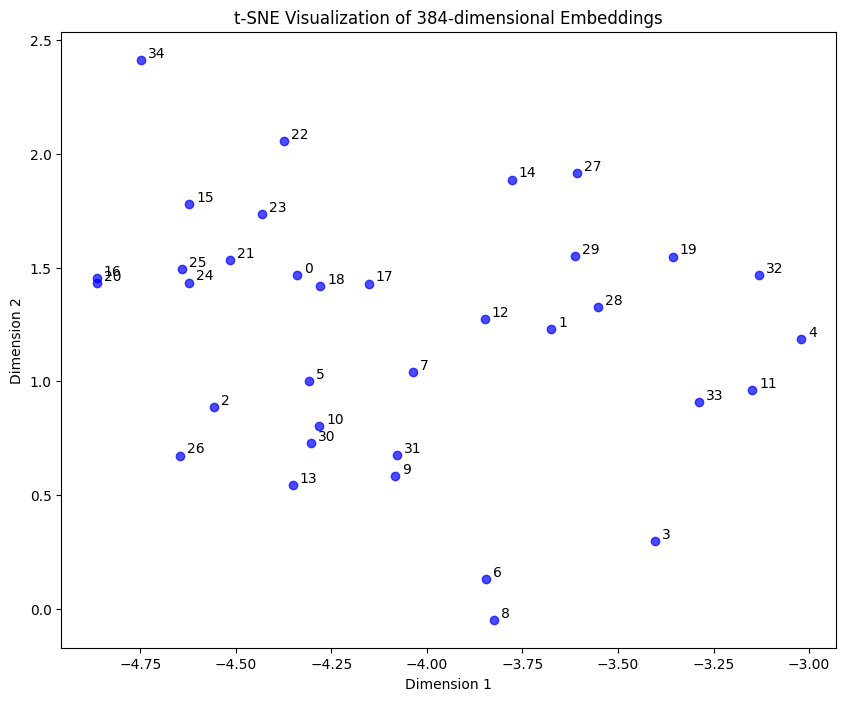

In [113]:
visualize_embeddings(embeddings_2d[:-1])

We'll also locate our **<span style="color: red">question</span>** is in this vector space.

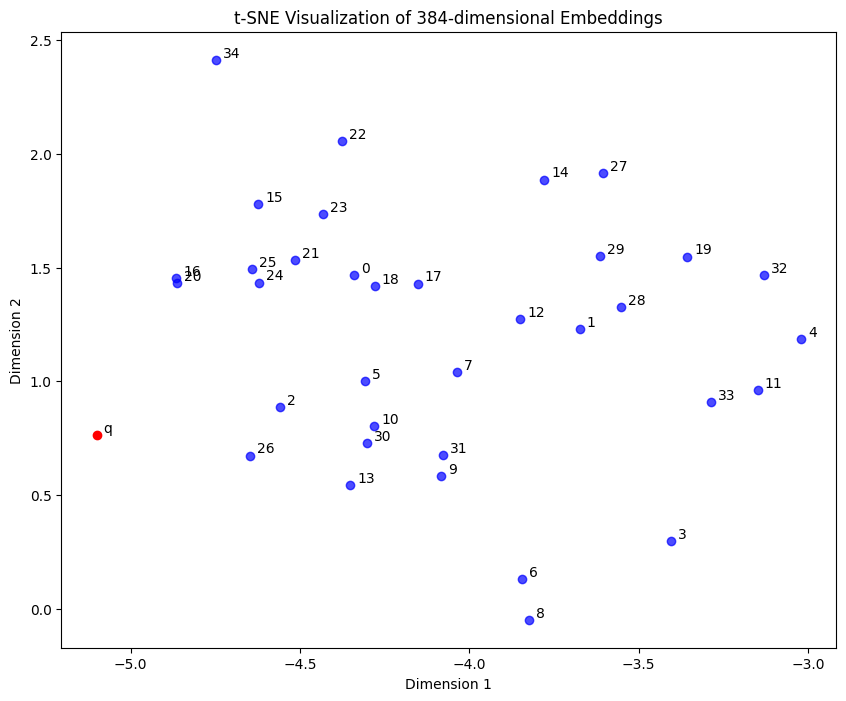

In [114]:
visualize_embeddings(embeddings_2d, True)

Next, we need to find the chunks of text that are semantically closer to our question. These are the pieces of text that are more likely to contain the answers to our question.

There are various approaches to achieve this, and we will use the **Euclidean Distance** to measure the similarity/closeness of data points.

To do this, we will use the **Nearest Neighbors** algorithm and find the top `k` data points that are closest to our question. In our example, we will retrieve the top 5 data points by default.

In [31]:
nn_2d = NearestNeighbors(n_neighbors=5, metric='cosine')
nn_2d.fit(embeddings_2d[:-1])

NearestNeighbors(metric='cosine')

In [32]:
neighbors = nn_2d.kneighbors(embeddings_2d[-1].reshape(1, -1), return_distance=False)
neighbors

array([[ 2,  0, 24, 30, 16]])

Let's now plot the closest points as **<span style="color: purple">purple</span>**.

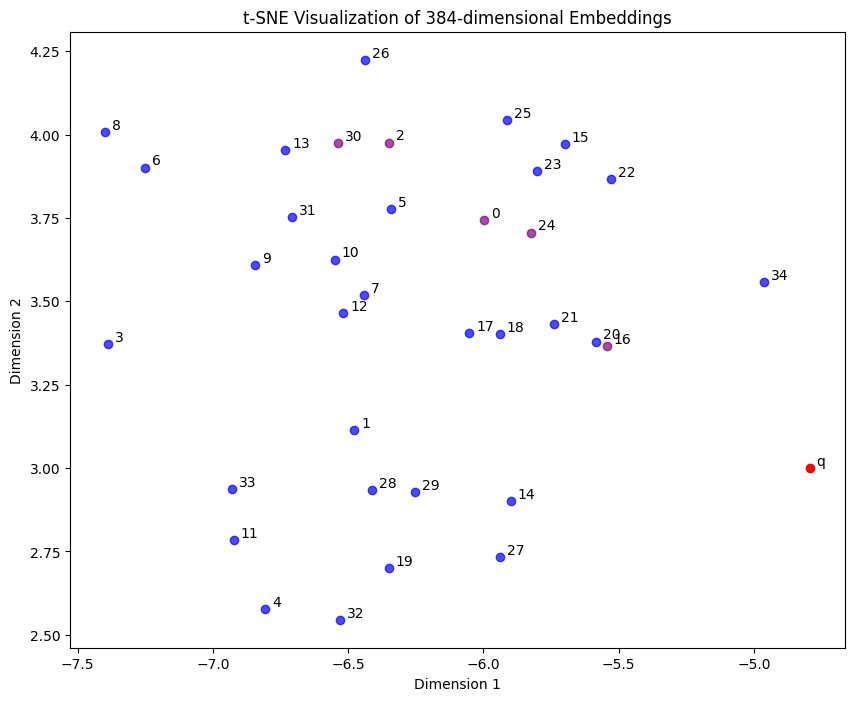

In [33]:
visualize_embeddings(embeddings_2d, True, neighbors)

## Semantic Search

As t-SNE is a non-linear algorithm and we lose some information during this process, we will not use the 2-dimensional vectors - those were used solely for visualization purposes.

We will repeat the same process as above but with the full 384-dimensional vectors instead.

Let's fit our Nearest Neighbors algorithm again, using the full-sized embeddings.

In [62]:
nn = NearestNeighbors(n_neighbors=2, metric='cosine')
nn.fit(embeddings)

NearestNeighbors(metric='cosine', n_neighbors=2)

We will once again convert our question into Embeddings.

In [103]:
# question = 'How many people does this pie serve?'
question = '請問金融管理專員在考慮註冊地監理機關是否充分時，會考慮哪些因素?'
emb_question = emb_function([question])

And, finally, find the chunks of text that are the closest to our question.

In [104]:
neighbors = nn.kneighbors(emb_question, return_distance=False)
neighbors

array([[10, 16]])

This way, we have the **top 5** chunks of text that are most likely to answer our question.

In [105]:
topn_chunks = [chunks[i] for i in neighbors.tolist()[0]]

## Prompt Building

Now, it is time to build our prompt.

Remember that we need to pass our context to it. In this case, we are calling our context *"Search results"* - the name doesn't really matter; the idea is the same.

We will iterate over our top chunks and append them to the prompt.

Finally, we will provide instructions to our model, ask our question, and receive our answer.

In [106]:
def build_prompt(question):
    prompt = ""


    prompt += "您是一名金融人工智慧助理，負責透過總結相關文件來提供答案。 你應該遵守這些規則:\n"\
              "1. 總結所提供的搜尋結果的內容\n"\
              "2. 如果聊天記錄中沒有找到相關訊息，請回覆'\我無法回答該問題\'.\n"\
              "3. 用中文簡短回答, Please answer with traditional chinese\n"\
              "\n"

    prompt += '搜尋結果:\n'

    for c in topn_chunks:
        prompt += c + '\n\n'
    prompt += f"\n\n\n詢問: {question}\n\n回答:"

    return prompt

In [107]:
prompt = build_prompt(question)
print(prompt)

您是一名金融人工智慧助理，負責透過總結相關文件來提供答案。 你應該遵守這些規則:
1. 總結所提供的搜尋結果的內容
2. 如果聊天記錄中沒有找到相關訊息，請回覆'\我無法回答該問題'.
3. 用中文簡短回答, Please answer with traditional chinese

搜尋結果:
[Page no. 11] "11 32. 第三，準大股東控權人（若適用，及小股東控權人）必須清楚詳 盡地表明其對有關機構的意向或計劃。金融管理專員會根據該名人士擔任類似或相關職位的紀錄，以及其實行上述計劃的財政能力，來考慮該計劃是否合適以及申請人實行該計劃的能力。金融管理專員的考慮可能包括對有關機構的未來計劃的評估及對有關業務的詳盡分析。如申請人提出的計劃未能促進有關機構的長期穩定及健康發展，申請人不會被界定為適當人選。 33. 第四，金融管理專員將考慮控權人的財政狀況、聲譽或行為會否 產生「連鎖影響」，動搖公眾對該機構的信心，以致危害該機構。例如，若控股公司或主要股東或與該股東有關連的公司面臨財政問題，便有可能導致該認可機構被擠提、在獲得存款及其他資金方面遇到困難，或向其他股東或準股東籌集新股本時出現困難。一般而言，股東的持股量越大，若股東面臨財政危機時，產生「連鎖影響」的風險便越高。產生連鎖影響的風險不一定局限於財政問題，其他有關控股公司或集團另一成員或與機構有關連的公司的不法或不道德行為的消息，均有可能損害對認可機構的信心。 34. 最後，金融管理專員一般預期大股東及小股東控權人能證明其於 有關機構的參與是代表其對有關機構的長期承諾，而且若有需要，他們願意及有能力提供額外資本。如大股東或小股東控權人的經營模式涉及為短期投資目的而持有機構的股本，一般不會被視作適當人選。 35. 金融管理專員一般會要求在香港成立為法團的認可機構的所有小 股東控權人及大股東控權人提交一份 聯繫證明書，承諾在有需要 時提供股本及／或流動資金以支持該機構。 36. 一般來說，金融管理專員的政策是，持有在香港成立為法團的認 可機構50%或以上股本的人士應為一間基礎穩健的銀行，或是一 間具備適當經驗、在金融界中信譽良好並受到監管的金融機構。金融管理專員在考慮不符合這項要求的人士的申請時，最關注的是確保申請人及申請人為成員之一的公司集團的任何其他成員對現有或建議成立的認可機構可能造成的任何風險

# watsonx.ai Inference

To complete our application, all we need to do now is send our prompt to our model and receive its answer based on the content we provided.

We will configure our environment with our credentials, define a helper function, and finally make inferences.

In [108]:
# Config watsonx.ai environment

api_key = "_oEth2aac5JKN8umgDE991KLhZ-aug96OFm19nVAEEaU"
project_id = "a80e2b76-716b-401a-af9b-cd1c0862fa62"
ibm_cloud_url = "https://us-south.ml.cloud.ibm.com"

creds = {
        "url": ibm_cloud_url,
        "apikey": api_key
}

In [100]:
def send_to_watsonxai(prompts,
                    model_name="meta-llama/llama-2-70b-chat",
                    decoding_method="greedy",
                    max_new_tokens=512,
                    min_new_tokens=0,
                    repetition_penalty=1.0
                    ):
    '''
   helper function for sending prompts and params to Watsonx.ai

    Args:
        prompts:list list of text prompts
        decoding:str Watsonx.ai parameter "sample" or "greedy"
        max_new_tok:int Watsonx.ai parameter for max new tokens/response returned
        temperature:float Watsonx.ai parameter for temperature (range 0>2)
        repetition_penalty:float Watsonx.ai parameter for repetition penalty (range 1.0 to 2.0)

    Returns: None
        prints response
    '''


    # Instantiate parameters for text generation
    model_params = {
        GenParams.DECODING_METHOD: decoding_method,
        GenParams.MIN_NEW_TOKENS: min_new_tokens,
        GenParams.MAX_NEW_TOKENS: max_new_tokens,
        GenParams.RANDOM_SEED: 42,
        GenParams.TEMPERATURE: 0,
        GenParams.REPETITION_PENALTY: repetition_penalty,
    }


    # Instantiate a model proxy object to send your requests
    model = Model(
        model_id=model_name,
        params=model_params,
        credentials=creds,
        project_id=project_id)


    for prompt in prompts:
        print(model.generate_text(prompt))


Below, we have a few examples of questions to use with both PDF files available.

Feel free to choose any of them or come up with your own questions to test your new application!

In [102]:
# Example questions for the g15:
#   對足夠流動資金的要求?
#   請問金融管理專員在考慮註冊地監理機關是否充分時，會考慮哪些因素？
#   我想查詢指數的委買跟委賣分析
#   DQ2 可以做到什麼功能?


question = "請問金融管理專員在考慮註冊地監理機關是否充分時，會考慮哪些因素？"
prompt = build_prompt(question)

response = send_to_watsonxai(prompts=[prompt], min_new_tokens=1)
print(response)

 金融管理專員在考慮註冊地監理機關是否充分時，會考慮以下因素：

1. 資本充足水平：金融管理專員會考慮註冊地監理機關的資本充足水平，以確保該機關具備足夠的財政資源，以履行其將來的義務。
2. 資產質素：金融管理專員會考慮註冊地監理機關的資產質素，以確保該機關的資產具備足夠的質量，以應對未來的業務風險。
3. 流動性：金融管理專員會考慮註冊地監理機關的流動性，以確保該機關具備足夠的流動資金，以履行其將來的義務。
4. 監管資本充足水平：金融管理專員會考慮註冊地監理機關的監管資本充足水平，以確保該機關具備足夠的財政資源，以履行其將來的義務。
5. 其他因素：金融管
None


In [95]:
print(prompt)

您是一名金融人工智慧助理，負責透過總結相關文件來提供答案。 你應該遵守這些規則:
1. 總結所提供的搜尋結果的內容
2. 如果聊天記錄中沒有找到相關訊息，請回覆'\我無法回答該問題'.
3. 用中文簡短回答

搜尋結果:
[Page no. 19] "19 第7段  對足夠流動資金的要求 59. 第7(a)段規定金融管理專員必須信納有關機構目前維持，並且如 獲認可會繼續維持足夠的流動資金， 以履行其將會到期或可能到 期的義務 。第7(b)段（補充第 7(a)段）訂明，金融管理專員必須 信納機構在獲得認可時及其後， 會遵從根據 《條例》 第97H(1)條 （即《銀行業( 流動性)規則》）訂立的規則。《銀行業( 流動性)規 則》載有適用於認可機構的流動性標準4，其中包括 — (a) 金融管理專員指定 某認可機構為「第 1類機構」的條文 ，而 「第 1類機構」須遵從《銀行業( 流動性 )規則》就流動性覆 蓋比率及穩定資金淨額 比率5所定的規定。其他並未被指定 為第 1類機構的認可機構（第 2類機構）須遵從《銀行業 (流 動性)規則》就流動性維持比率所定的規定6； (b) 金融管理專員指定某 「第 2類機構」為「第 2A類機構」的 條文，而除流動性維持比率外，「第 2A類機構」亦須遵從 《銀行業 (流動性 )規則》就 核心資金比率 所定的規定； (c) 4項流動性比率，即流動性覆蓋比率、 流動性維持比 率、穩 定資金淨額比率及核心資金比率的最低水平，以及有關計算 方法；以及 (d) 根據《條例》第 97I條，認可機構須遵從 的在發生《銀行業 (流動性) 規則》所載的流動性相關事件時 須即時通知金融管 理專員的訂明通知規定 ，以及金融管理專員在接 獲有關該類 事件的通知時會採取的行動。 60. 根據《條例》 第97M條，金融管理專員已 發出實務守則，就根據 4 《監管政策手冊》單元 LM-1「流動性風險監管制度」就《銀行業( 流動性 )規則》的應用 提供指引。 5 流動性覆蓋比率及穩定資金淨額比率為巴塞爾委員會推出作為流動性管理及監管的最低 國際標準的兩項量化指標 。 6 從業務規模或業務運作的複雜程度來考慮， 第1類機構一般 為有重大國際風險承擔 或對 本地銀行體系的整體穩定有重要影響的機構。第 2類機構一般為本地業務規模相對細小及 簡單的機構 。"

[Page no